In [ ]:
!pip install numpy
!pip install pandas
!pip install Connectome-Utilities
!pip install connectome-analysis
!pip install scipy

# The dangers of sampling

In connectomics, a lot of data we use stems from experiments where a small subset of a connectome is sampled.
That is, brain slices are prepared, then a small number of neurons (e.g., 8) is patched. By making one of the neurons spike and recording from all others, we can then test for the presence of connections.
The result is the submatrix of connectivity between the sampled neurons.

This leads to the question how representative the samples are for the overall connectome. How reliable are qualitative results obtained this way?

In principle this can be investigated mathematically:
Let p_true be the probability of connectivity in the actual, full connectome. Then the number of connections found in, e.g., 250 samples of 8 neurons (8 * 7 = 56 pairs) follows a binomial distribution with n=250 * 56, p=p_true. See the code cell below:

In [ ]:
from scipy.stats import binom

n = 8 # number of neurons sampled concurrently
n_pairs = n * (n - 1) # number of pairs, i.e., possible connections
p_true = 0.05 # exemplary value
n_submat_sampled = 250 # number of submatrices sampled, i.e., number of slices tested. This is a generous number that would require a lot of work.

# The distribution for the results of the sampling
distr = binom(n_submat_sampled * n_pairs, p_true)

# Expected outcomes: Expected estimate of p from the data and the expected error of the estimate
expected_p_estimate = distr.mean() / (n_submat_sampled * n_pairs)
expected_err = distr.std() / (n_submat_sampled * n_pairs)
display(expected_p_estimate, expected_err)

As we see, the experiment is expected to yield the correct estimated connection probability on average, and with a small expected error around it.

Can you see the potential issue with this analysis?

It assumes that a specific algorithm is a good description of connectivity. In this case, it assumes that connections are formed stochastically independently with uniform probability. That is at the basis of using the binomial distribution. We call this Erdos-Renyi (ER) connectivity - this is in general a very weak model.

The binomial distribution resulting from the ER assumption also is much narrower than in actual, biological connectomes. In biological connectomes, the number of connections formed by a single neuron follows a very wide, geometric distribution. And the wider the distribution you sample from is, the larger your expected error:

In [ ]:
from scipy.stats import geom
# Geometric distribution with the expected value
distr = geom(1 / (n_submat_sampled * n_pairs * p_true))

# Expected outcomes: Expected estimate of p from the data and the expected error of the estimate
expected_p_estimate = distr.mean() / (n_submat_sampled * n_pairs)
expected_err = distr.std() / (n_submat_sampled * n_pairs)
display(expected_p_estimate, expected_err)

We see that now the expected relative error is almost 10%. 

## The bigger problem
However, the bigger problem is the assumption that connectivity is:
1. spatially non-structured, i.e., independent of neuron locations.
2. Stochastically independent, i.e., the presence or absence of one connection does not depend on other connections.

The argument for the first assumption is that usually connectivity at low distances is measured. And the lower the range of distances considered, the lower the impact of distance-dependence. We can investigate to what degree that is true.

## Recreating the sampling used in experiments stochastically

The samples taken are usually depicted in a plot such as the following, from Peng et al., 2024.

The relative soma locations of all samples from all slices are considered and indicated. One neuron of the pair is always at the center, the location of the other is indicated as a dot. Color of the dot indicates connectivity.

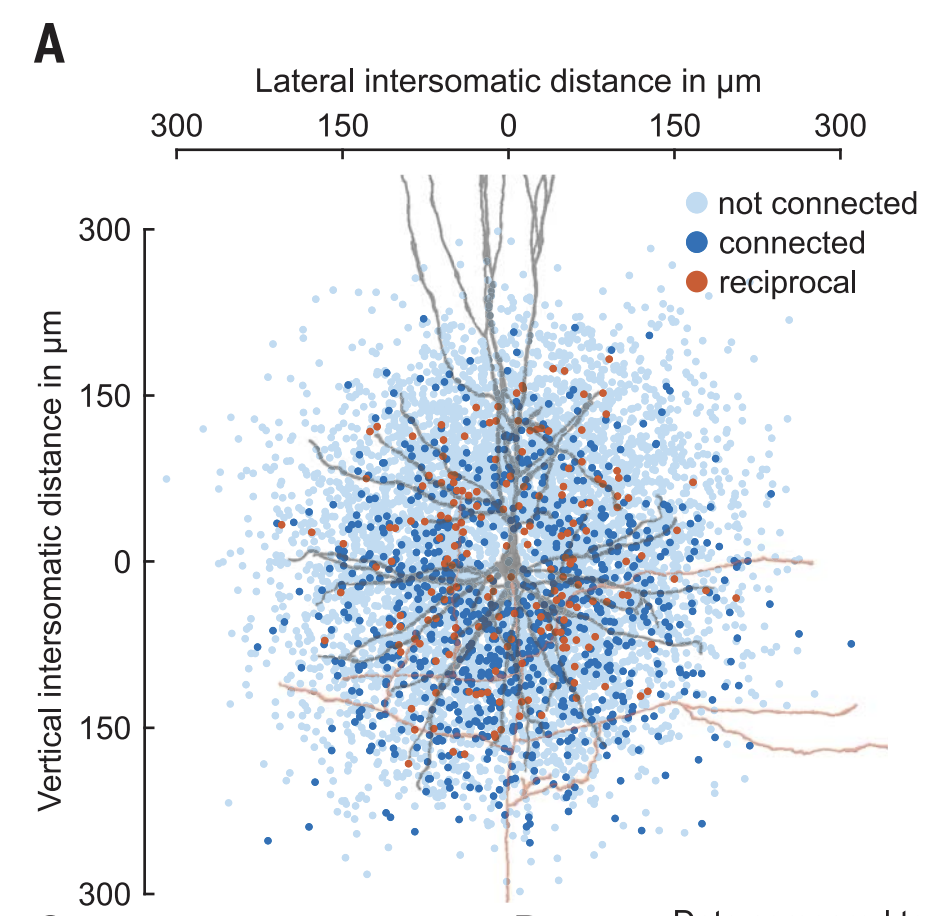

We see that the samples are mostly at low distances and gradually grow thinner for longer distances.
We can recreate that kind of sampling using an actual, biological connectome.

Here, we load the connectivity of the MICrONS data: An electron microscopic reconstruction of a cubic mm of mouse brain tissue. With this technique, all synaptic connections within the volume are likely found. However, it is not guaranteed to be 100% accurate, as reconstruction errors are possible.

In [ ]:
import conntility
import pandas
import numpy

from scipy.spatial.distance import pdist, squareform

# Obtain from: https://doi.org/10.5281/zenodo.13849415
fn = "./microns_mm3_connectome_v1181.h5"
# Loading the data
m = conntility.ConnectivityMatrix.from_h5(fn, group_name="condensed")

Connectomics studies in cortex often focus on a single cortical layer.
Here, we display the counts of cell types associated with all neurons in the connectome. 
Then we pick a layer, identify the cell types associated with that layer and use the .index function to focus on the connectivity within that layer only.

In [ ]:
display("Connectome contains {0} neurons".format(len(m)))
display(m.vertices["cell_type"].value_counts().sort_index())

In [ ]:
# Here we pick L4 and L5. Create list of cell types in that layer. See output of previous cell for list of all cell types.
cell_types = ["L4b", "L4a", "L4c"]
# Create submatrix of L4/5 only.
m = m.index("cell_type").isin(cell_types)
display("Sub-connectome between {1} neurons contains {0} neurons".format(len(m), cell_types))

Next, an experimenter would create a slice of the tissue. 
We can use the .slice function to approximate this. The location and angle of the slice can be customized. 
The slicing method uses the coordinates of the neurons to determine whether they are inside the slice. 
In the loaded connectome, we have access to the soma locations of neurons in nanometers ("x_nn", "y_nm", "z_nm").

In [ ]:
from matplotlib import pyplot as plt

# Method to create a sub-connectome within a slice
slc = m.slice(0.0, # The angle of the slice. Describes an angle in the plane given by the "columns_slice" coordinates.
              0.0, # offset of the slice from the center. Here, we stick to the center
              200000, # Thickness of the slice. In the units given by the coordinates used. Here: nanometers.
              columns_slice=["x_nm", "z_nm"], # Rotation of slice defined in these coordinates
              column_y="y_nm") # The "vertical" direction of the slice

plt.scatter(m.vertices["x_nm"], m.vertices["z_nm"], c="grey", s=2, label="All neurons")
plt.scatter(slc.vertices["x_nm"], slc.vertices["z_nm"], c="red", s=2, label="Neurons in slice")
plt.legend()
plt.gca().set_xlabel("x (nanometers)")
plt.gca().set_ylabel("z (nanometers)")

Next, we emulate stochastically the sampling procedure.
This uses the .patch_sample function.

The function uses the vague observation we made above: That relative locations become gradually less likely with distance. It desribes this as a 2-dimensional gaussian with an exclusion zone for very low distances.

In [ ]:
smpl = slc.patch_sample(
    8, # Number of neurons sampled together
    [0.0, 0.0], # Placement of the sample. [0, 0] indicates the center of the slice
    [  # Sampling is modeled as a 2d gaussian. This is the covariance matrix of said gaussian.
        [125000 ** 2, 0.0], # Units are still in nm. 125000 ** 2 indicates a standard deviation of 125 um.
        [0.0, 125000 ** 2]  # That means distances between sampled neurons will be around that value.
    ],
    ["x_nm", "y_nm"], # Which coordinates define the plane of the slice.append
    avoidance_range=20.0 # Pairs closer than this excluded
)
display(smpl.vertices[["x_nm", "y_nm"]] / 1000.0) # Nearby neurons sampled

We can sample many times and compare the relative locations samples visually to the image above.

Note that the connectome used is different, so the amount of connectivity can differ. Here, we are trying to match the overall sampling strategy.

In [ ]:
# To put the results
all_rel_locs = [] # Relative locations sampled. One entry per pair
all_is_con = [] # Which pairs are connected?
all_is_rec = [] # Which pairs are reciprocally connected?

for _ in range(50): # We sample fifty times
    # Create a sampling of eight neurons
    smpl = slc.patch_sample(
        8, 
        numpy.random.rand(2) * 25000 - 12500, # Random offset
        [ 
            [125000 ** 2, 0.0], 
            [0.0, 125000 ** 2]  
        ],
        ["x_nm", "y_nm"]
    )
    # Get the relative locations of neurons sampled. We divide by 1000 to convert from nm to um.
    smpl_loc_um = smpl.vertices[["y_nm", "x_nm"]].values / 1000
    # numpy magic.
    rel_loc_um = smpl_loc_um.reshape((-1, 1, 2)) - smpl_loc_um.reshape((1, -1, 2))
    # From 8 x 8 x 2 array to 64 x 2 array
    rel_loc_um = rel_loc_um.reshape((-1, 2))
    # delta x, delta y both 0 means this is a pair of a neuron with itself. We want to exclude them
    valid = rel_loc_um.sum(axis=1) != 0
    rel_loc_um = rel_loc_um[valid]
    # Append relative locations, connectivity and reciprocal connectivity.
    all_is_con.extend(smpl.array.astype(bool).flatten()[valid])
    all_is_rec.extend(smpl.to_reciprocal().array.astype(bool).flatten()[valid])
    all_rel_locs.append(rel_loc_um)

# Depict results
all_rel_locs = numpy.vstack(all_rel_locs)
all_is_con = numpy.array(all_is_con)
all_is_rec = numpy.array(all_is_rec)
plt.figure(figsize=(3, 3))
plt.scatter(all_rel_locs[~all_is_con, 0], all_rel_locs[~all_is_con, 1], s=4, c=[0.7, 0.7, 1.0])
plt.scatter(all_rel_locs[all_is_con, 0], all_rel_locs[all_is_con, 1], s=5, c="blue")
plt.scatter(all_rel_locs[all_is_rec, 0], all_rel_locs[all_is_rec, 1], s=5, c="orange")
plt.gca().set_frame_on(False)
plt.axis("equal")

## Sample connectivity and calculate connectivity metrics

Now we can sample connectivity systematically. 

We write a simple function to sample eight neurons at a time over and over, and return the number of connections, the number of reciprocal connections and the mean distance of pairs sampled.

In the function we use a "scale_parameter" that determines the overall spatial scale that pairs are sampled over. Larger values will lead to sampling at larger pairwise distances.

In [ ]:
def sample(s, scale_parameter, nsmpl, nneuron=8):
    ncon = []; nrec = []; npair = []
    actual_dists = []
    for _ in range(nsmpl):
        p = s.patch_sample(nneuron,
                           [0, 0],
                           [[(scale_parameter * 1000) ** 2, 0],
                            [0, (scale_parameter * 1000) ** 2]], 
                            columns_xy=["slice_x", "slice_y"])
        r = p.to_reciprocal()
        ncon.append(len(p.edges))
        nrec.append(len(r.edges))
        npair.append(len(p) * (len(p) - 1))
        actual_dists.append(pdist(p.vertices[["x_nm", "y_nm"]] / 1000).mean())

    return pandas.DataFrame({
        "ncon": ncon,
        "npair": npair,
        "nrec": nrec,
        "mn_dist": actual_dists
    })

smpl_df = sample(slc, 100.0, 10)
display(smpl_df.head())

## Overexpression of reciprocity..?
One question we can ask is: Is reciprocal, i.e., bidirectional connectivity overexpressed?

### Results in favor
Perin et al., 2012, PNAS found that in connections between L5 PCs of rats, reciprocal connections are more abundant than expected from the overall connection probability. 

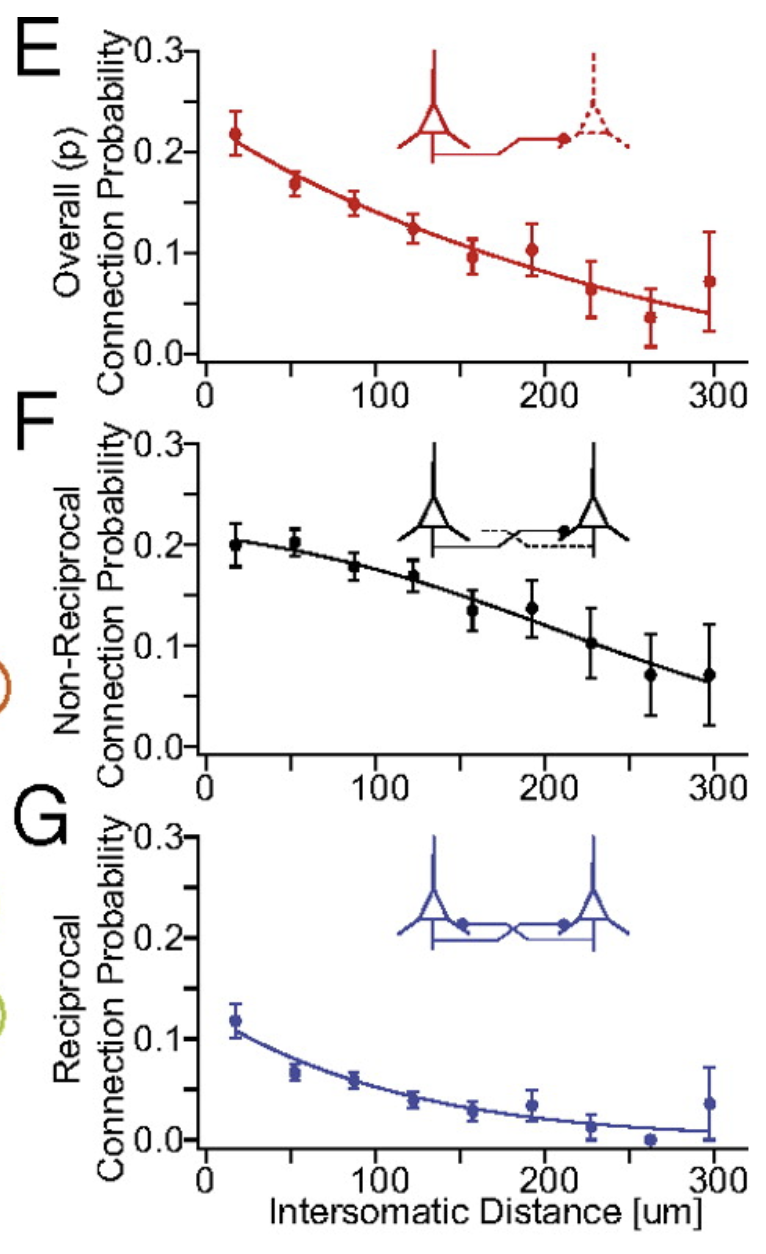

### Results against
Conversely, Peng et al., 2024, Science found that in human temporal cortex this is not the case.

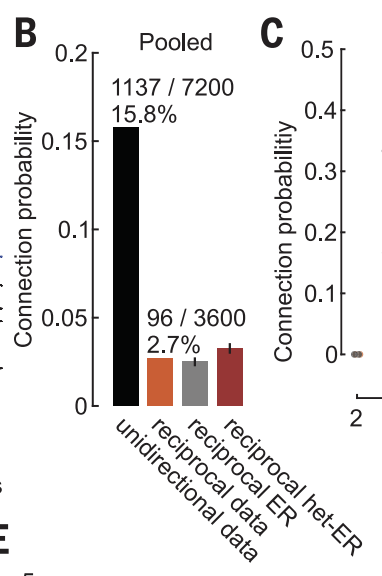

How about in our data? (Reminder, this is the MICrONS dataset, i.e., mouse visual cortex)


We write a function that analyzes the output of our sampling procedure with respect to this question.

In [ ]:
def reciprocal_overexpression(df):
    # df: pandas.DataFrame. Four columns: npair, ncon, nrec, mn_dist
    dfsum = df[["npair", "ncon", "nrec"]].sum() 
    puni = dfsum["ncon"] / dfsum["npair"] # The overall connection probability: Connections divided by pairs
    prec = dfsum["nrec"] / dfsum["npair"]  # The reciprocal connection probability.
    # If connections in both directions are independent, then the probability of both existing is the square of puni.
    expected_rec = puni ** 2 # The expected reciprocal connection probability.

    # Return the overexpression factor, i.e., actual result divided by expected result.
    return pandas.Series([prec / expected_rec], name="reciprocal overexpression",
                         index=pandas.Index([numpy.mean(df["mn_dist"])], name="mean distance"))

reciprocal_overexpression(smpl_df)

Now let's gather a lot of samples for various values of the scale parameter.
Here, to get more robust data, we sample 16 neurons at a time (16 * 15 pairs).

In [ ]:
scales_to_use = [50, 100, 150, 200, 250, 300, 400, 500]
nsmpl = 500 #1000

numpy.random.seed(12345)
smpl_dfs = []
for scale in scales_to_use:
    print("Sampling at scale {0}".format(scale))
    smpl_df = sample(slc, scale, nsmpl, nneuron=16)
    smpl_dfs.append(smpl_df)

smpls_concat = pandas.concat(smpl_dfs, axis=0, keys=scales_to_use, names=["scale"])
rec_overexp_result = smpls_concat.groupby("scale").apply(reciprocal_overexpression)

A quick plot of the results, and how they change with the mean distance sampled.

In [ ]:
plt.plot(rec_overexp_result.reset_index()["mean distance"], rec_overexp_result.values, marker='o')
plt.gca().set_xlabel("Mean pairwise distance")
plt.gca().set_ylabel("Overexpression factor")

We note that the result seems to depend on our sampling! 

This already indicates that one must be really careful when interpreting data from subsampled connectomics experiments. The results may be specific to the spatial scale considered.

Overall, the overexpression of reciprocal connections seems to be larger at higher distances, but the results also vary drastically and seem rather noisy (despite sampling so many pairs). 

## Considering the full matrix
So what is the verdict? How much overexpression of reciprocity is there? Since we have the complete connectome, we can analyze that instead of relying on individual samples.

To that end, we calculate the full matrix of pairwise distances and then perform instead an exhaustive sampling: All pairs of neurons within a specified distance cutoff are considered exactly once.

In [ ]:
D = squareform(pdist(m.vertices[["x_nm", "y_nm", "z_nm"]] / 1000))  # Using um, hence divide by 1000
A = m.array  # Adjacency (connectivity) matrix as numpy array
R = m.to_reciprocal().array  # Same, but only reciprocal connections are considered.

mx_dists = numpy.arange(25, 450, 25)
full_smpl_res = []
for max_dist in mx_dists:
    print("Analyzing below {0} um".format(max_dist))
    v = (D < max_dist) & (D > 0)  # distance = 0 along the main diagonal, comparing D > 0 excludes those samples.
    puni = A[v].mean(); prec = R[v].mean()
    expected_rec = puni ** 2
    mean_dists = D[v].mean()
    rec_over = prec / expected_rec
    full_smpl_res.append(
        pandas.Series({"max distance": max_dist, "mean distance": mean_dists,
                       "reciprocal overexpression": rec_over})
    )
full_smpl_res = pandas.concat(full_smpl_res, axis=1).transpose()




In [ ]:
plt.plot(full_smpl_res["mean distance"], full_smpl_res["reciprocal overexpression"], marker='o', label="Full connectome")
plt.plot(rec_overexp_result.reset_index()["mean distance"], rec_overexp_result.values, marker='o', label="Sampled")
plt.gca().set_xlabel("Mean pairwise distance")
plt.gca().set_ylabel("Overexpression factor")
plt.legend()

## Result

We see that our initial idea was right: Overexpression of reciprocal connections, at least in this particular connectome depends on the overall spatial scale considered.

When considering results from sampling small groups of neurons at a time, caution must be applied the the sampled scale considered.

We also see that this sampling process itself leads to unreliable results.
That is another caveat, related to the points illustrated at the start of this notebook: Biological connectivity is characterized by long-tailed distributions, hence sampling less reliable than one might think.

## One last caveat
We have seen that the sampling procedure leads to noisy results.

But is it at least representative in terms of the relative locations sampled? As we have seen, connectivity and its results are highly distance-dependent. Previously, we took this into account by considering the mean pairwise distance of sampled pairs. But is it a representative sample of neuron pairs?

To that end, we once again consider the relative offset of neuron locations from samples. Then we compare them to the relative offsets in the entire circuit.

In [ ]:
def sample_relative_locations_only(s, scale_parameter, nsmpl, nneuron=8):
    rel_loc_smpl = []
    for _ in range(nsmpl):
        smpl = s.patch_sample(nneuron,
                           [0, 0],
                           [[(scale_parameter * 1000) ** 2, 0],
                            [0, (scale_parameter * 1000) ** 2]], 
                            columns_xy=["slice_x", "slice_y"])
        
        # We have used the next few lines previously. Explanations found above.
        smpl_loc_um = smpl.vertices[["y_nm", "x_nm"]].values / 1000
        rel_loc_um = smpl_loc_um.reshape((-1, 1, 2)) - smpl_loc_um.reshape((1, -1, 2))
        rel_loc_um = rel_loc_um.reshape((-1, 2))
        valid = rel_loc_um.sum(axis=1) != 0
        rel_loc_um = rel_loc_um[valid]
        rel_loc_smpl.append(pandas.DataFrame(rel_loc_um, columns=["dx", "dy"]))
    return pandas.concat(rel_loc_smpl, axis=0)
    
rel_loc_df = sample_relative_locations_only(slc, 100, 250, nneuron=16)
bins = numpy.linspace(-150, 150, 31)

rel_loc_binned = rel_loc_df.apply(numpy.digitize, axis=0, bins=bins)
rel_loc_counts = rel_loc_binned.value_counts()
reidx = numpy.arange(len(bins) - 1) + 1
rel_loc_counts = rel_loc_counts.unstack("dx").reindex(index=reidx, columns=reidx)
plt.imshow(rel_loc_counts.values)

In [ ]:
dx = (m.vertices["x_nm"].values.reshape((-1, 1)) - m.vertices["x_nm"].values.reshape((1, -1))) / 1000
dy = (m.vertices["y_nm"].values.reshape((-1, 1)) - m.vertices["y_nm"].values.reshape((1, -1))) / 1000

dx_binned = numpy.digitize(dx[numpy.triu_indices_from(dx)], bins)
dy_binned = numpy.digitize(dy[numpy.triu_indices_from(dy)], bins)
rel_loc_binned_full = pandas.DataFrame({"dx": dx_binned, "dy": dy_binned})

rel_loc_counts_full = rel_loc_binned_full.value_counts()
rel_loc_counts_full = rel_loc_counts_full.unstack("dx").reindex(index=reidx, columns=reidx)
plt.imshow(rel_loc_counts_full.values)